# Cut the image and semantic image into your model input image

In [1]:
import numpy as np
from skimage import io
import napari
import sys
import os

utils_path = os.path.abspath(os.path.join('..', 'utils'))

if utils_path not in sys.path:
    sys.path.append(utils_path)
import file_utilities as fu

In [2]:
# Get the file path
file_path = fu.choose_file()
image = io.imread(file_path)

# Get the file path
file_path = fu.choose_file()
mask = io.imread(file_path)


Selected File: C:/Users/Ding-Yang/Desktop/Thesis code/Axons-extraction/example data/less_intensive/top_hat/top_hat.tiff
Selected File: C:/Users/Ding-Yang/Desktop/Thesis code/Axons-extraction/example data/less_intensive/semantic image/label_wih_border_mask.tif


## read augmentation files

In [14]:
import os
import glob
import tifffile
from tkinter import filedialog, Tk, messagebox

def read_augmentation_images():
    # 彈窗提醒用戶選擇目錄
    root = Tk()
    root.attributes("-topmost", True)
    root.withdraw()
    
    # 彈窗提醒
    messagebox.showinfo("Choose Directory", "Please choose a folder containing the augmentation datasets.")
    
    # 打開目錄選擇對話框
    augmentation_directory = filedialog.askdirectory(
        title="Select the Augmentation folder"
    )
    root.destroy()

    # 如果用戶未選擇目錄
    if not augmentation_directory:
        raise Exception("No directory selected. Operation aborted.")

    # 確保選擇的目錄中存在與原始圖像目錄匹配的子文件夾
    image_directory = os.path.join(augmentation_directory, "image")
    mask_directory = os.path.join(augmentation_directory, "mask")
    print(image_directory)

    # 確認圖像和標籤目錄是否存在
    if os.path.exists(image_directory) and os.path.exists(mask_directory):
        # 讀取圖像文件
        image_files = glob.glob(os.path.join(image_directory, "*.tif"))
        images = {os.path.splitext(os.path.basename(image_file))[0]: tifffile.imread(image_file) for image_file in image_files}

        # 讀取標籤文件
        mask_files = glob.glob(os.path.join(mask_directory, "*.tif"))
        masks = {os.path.splitext(os.path.basename(mask_file))[0]: tifffile.imread(mask_file) for mask_file in mask_files}

        # 檢查是否成功讀取
        if images and masks:
            print(f"Read {len(images)} images and {len(masks)} masks")
        else:
            print("Failed to read images and masks")
        return {"image": images, "mask": masks}
    else:
        raise Exception(f"Image directory or mask directory does not exist in {augmentation_directory}")

# 使用方式
result_dict = read_augmentation_images()


C:/Users/Ding-Yang/Desktop/Thesis code/Axons-extraction/example data/Augmentation/less intensive\image
Read 1 images and 1 masks


In [15]:
def check_shapes(image_dict):
    # Initialize lists to store shapes and their corresponding keys
    image_shapes = []
    mask_shapes = []
    image_keys = []
    mask_keys = []

    # Iterate over the items in the dictionary
    for key, sub_dict in image_dict.items():
        for sub_key, value in sub_dict.items():
            if 'image' in sub_key.lower():
                image_shapes.append(value.shape)
                image_keys.append(sub_key)
            elif 'mask' in sub_key.lower():
                mask_shapes.append(value.shape)
                mask_keys.append(sub_key)

    # Check if all image shapes are the same
    same_image_shapes = all(shape == image_shapes[0] for shape in image_shapes)

    # Check if all mask shapes are the same
    same_mask_shapes = all(shape == mask_shapes[0] for shape in mask_shapes)

    if same_image_shapes:
        print("All images have the same shape:", image_shapes[0])
    else:
        print("Images have different shapes. All images must have the same shape")
        for i, shape in enumerate(image_shapes):
            if shape != image_shapes[0]:
                raise ValueError(f"Image {image_keys[i]} has shape:", shape)

    if same_mask_shapes:
        print("All masks have the same shape:", mask_shapes[0])
    else:
        print("Masks have different shapes. All masks must have the same shape")
        for i, shape in enumerate(mask_shapes):
            if shape != mask_shapes[0]:
                raise ValueError(f"Mask {mask_keys[i]} has shape:", shape)

    if image_shapes[0] == mask_shapes[0]:
        print("All images and masks have same shapes", mask_shapes[0])
        return image_shapes[0]
    else:
        raise ValueError("Images and masks have different shapes")

# Usage
image_shape = check_shapes(result_dict)


All images have the same shape: (17, 1024, 1024)
All masks have the same shape: (17, 1024, 1024)
All images and masks have same shapes (17, 1024, 1024)


In [16]:
image_keys = list(result_dict['image'].keys())
mask_keys = list(result_dict['mask'].keys())

# 找到匹配的键对
matched_pairs = [(image_key, mask_key) for image_key in image_keys for mask_key in mask_keys if image_key.split(' ')[0] == mask_key.split(' ')[0]]

# 打印匹配的键对
for i, (image_key, mask_key) in enumerate(matched_pairs):
    print("image:", i)
    print("Image key:", image_key)
    print("Mask key:", mask_key)

    print()


image: 0
Image key: RandomGamma_RandomFlip_transpose 0 Image
Mask key: RandomGamma_RandomFlip_transpose 0 Mask



## cute into patches and make them into training inout shape

In [17]:
import numpy as np
import math

def adjust_image_size(result_dict, z_target = None):
    # Get the shape of the images
    image_shapes = check_shapes(result_dict)
    if len(result_dict['image']) != len(result_dict['mask']):
        raise ValueError("Your image and mask couldn't match")

    # Get the shape of the images
    oz, ox, oy = image_shapes
    if z_target == None:
        z_target = round(oz / 32) * 32
        print(f"Adjusting your result_dict image shape from {image_shapes} into {(z_target, ox, oy)}...")
    else:        
        # Check if z_target is divisible by 32
        if z_target % 32 != 0:
            raise ValueError("z_target must be divisible by 32")

    # make adjusted_result dic
    adjusted_result = {'image': {}, 'mask': {}}
    num_images = len(result_dict['image'])
    num_adjusted_images = len(result_dict['image'])
    for i in range(num_adjusted_images):
        adjusted_image_key = f"image {i+1}"
        adjusted_mask_key = f"mask {i+1}"
        adjusted_result['image'][adjusted_image_key] = np.zeros((z_target, ox, oy), dtype=result_dict['image'][list(result_dict['image'].keys())[i]].dtype)
        adjusted_result['mask'][adjusted_mask_key] = np.zeros((z_target, ox, oy), dtype=result_dict['mask'][list(result_dict['mask'].keys())[i]].dtype)

    # Check if z_target is higher or lower than the current z
    if oz > z_target:
        # Higher, crop the images
        image_keys = list(result_dict['image'].keys())
        mask_keys = list(result_dict['mask'].keys())
        
        # 找到匹配的键对
        matched_pairs = [(image_key, mask_key) for image_key in image_keys for mask_key in mask_keys if image_key.split(' ')[0] == mask_key.split(' ')[0]]
        
        # 打印匹配的键对count, value in enumerate(values
        for i, (image_key, mask_key) in enumerate(matched_pairs):
            key_adjust_image = list(adjusted_result['image'].keys())[i]
            adjusted_result["image"][key_adjust_image] = np.copy(result_dict['image'][image_key][0:z_target])

            key_adjust_mask = list(adjusted_result['mask'].keys())[i]
            adjusted_result["mask"][key_adjust_mask] = np.copy(result_dict['mask'][mask_key][0:z_target])


    elif oz < z_target:
        # Lower, pad the images
        # Higher, crop the images
        image_keys = list(result_dict['image'].keys())
        mask_keys = list(result_dict['mask'].keys())
        
        # 找到匹配的键对
        matched_pairs = [(image_key, mask_key) for image_key in image_keys for mask_key in mask_keys if image_key.split(' ')[0] == mask_key.split(' ')[0]]
        
        # 打印匹配的键对count, value in enumerate(values
        for i, (image_key, mask_key) in enumerate(matched_pairs):
            key_adjust_image = list(adjusted_result['image'].keys())[i]
            adjusted_result["image"][key_adjust_image][0:oz] = np.copy(result_dict['image'][image_key])
            adjusted_result["image"][key_adjust_image][oz:z_target] = np.copy(result_dict['image'][image_key][0:z_target - oz])


            key_adjust_mask = list(adjusted_result['mask'].keys())[i]
            adjusted_result["mask"][key_adjust_mask][0:oz] = np.copy(result_dict['mask'][mask_key])
            adjusted_result["mask"][key_adjust_mask][oz:z_target] = np.copy(result_dict['mask'][mask_key][0:z_target - oz])
    else:
        print("Your z_target has the same size as the original of the image. The images do not change.")
        adjusted_result = result_dict
    print("Finish!")
    return adjusted_result

# Usage
adjusted_result = adjust_image_size(result_dict)


All images have the same shape: (17, 1024, 1024)
All masks have the same shape: (17, 1024, 1024)
All images and masks have same shapes (17, 1024, 1024)
Adjusting your result_dict image shape from (17, 1024, 1024) into (32, 1024, 1024)...
Finish!


In [18]:
z, _, _ = adjusted_result['image']['image 1'].shape
reszie_image = np.zeros((z, 1024, 1024))
reszie_mask = np.zeros((z, 1024, 1024))

if image.shape[0] <= z:
    reszie_image[0:image.shape[0]] = image
    reszie_image[image.shape[0]:z] = image[0:z-image.shape[0]]
    reszie_mask[0:image.shape[0]] = mask
    reszie_mask[image.shape[0]:z] = mask[0:z-mask.shape[0]]
else:
    reszie_image = image[0:z]
    reszie_mask = mask[0:z]

image = reszie_image

mask = reszie_mask

In [19]:
from patchify import patchify, unpatchify
img_patches = patchify(image, (32, 64, 64), step=64)  #Step=64 for 64 patches means no overlap
mask_patches = patchify(mask, (32, 64, 64), step=64)  
print(img_patches.shape,mask_patches.shape)

image_dataset = np.reshape(img_patches, (-1, img_patches.shape[3], img_patches.shape[4], img_patches.shape[5]))
mask_dataset = np.reshape(mask_patches, (-1, mask_patches.shape[3], mask_patches.shape[4], mask_patches.shape[5]))

print(image_dataset.shape)  # n_patches, x, y, z

(1, 16, 16, 32, 64, 64) (1, 16, 16, 32, 64, 64)
(256, 32, 64, 64)


In [20]:
image_keys = list(adjusted_result['image'].keys())
mask_keys = list(adjusted_result['mask'].keys())
matched_pairs = [(image_keys[i], mask_keys[i]) for i in range(min(len(image_keys), len(mask_keys)))]
for i, (image_key, mask_key) in enumerate(matched_pairs):
    print(f"patching image {i+1}")
    img_patches = patchify(adjusted_result['image'][image_key], (32, 64, 64), step=64)  #Step=64 for 64 patches means no overlap
    mask_patches = patchify(adjusted_result['mask'][mask_key], (32, 64, 64), step=64)  
    input_img = np.reshape(img_patches, (-1, img_patches.shape[3], img_patches.shape[4], img_patches.shape[5]))
    input_mask = np.reshape(mask_patches, (-1, mask_patches.shape[3], mask_patches.shape[4], mask_patches.shape[5]))
    image_dataset = np.concatenate([image_dataset, input_img], axis=0)
    mask_dataset = np.concatenate([mask_dataset, input_mask], axis=0)


patching image 1


# If you make multiple training images want to use

In [21]:

# 将两个数组沿着第一个轴合并
merged_image = np.concatenate((image_dataset_1, image_dataset), axis=0)
merged_mask = np.concatenate((mask_dataset_1, mask_dataset), axis=0)

# 打印合并后的数组形状
print(merged_image.shape)


NameError: name 'image_dataset_1' is not defined

In [ ]:
image_dataset = np.copy(merged_image)
mask_dataset =np.copy(merged_mask)
image_dataset.shape

# check the GT image and preprocessing is match

(512, 32, 64, 64) (512, 32, 64, 64)
422


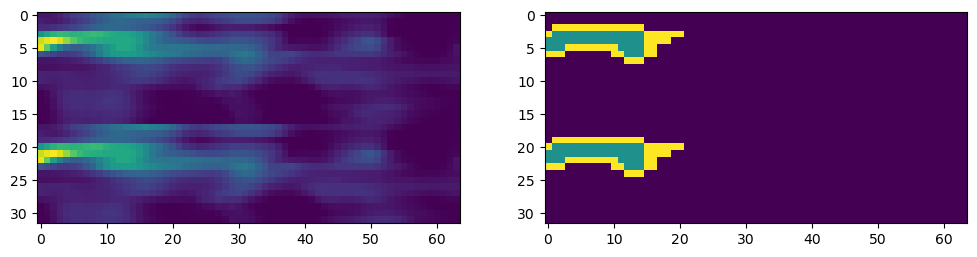

In [25]:
#Sanity check, view few mages
import random
import numpy as np
from matplotlib import pyplot as plt

print(image_dataset.shape, mask_dataset.shape)
image_number = random.randint(0, len(image_dataset))
print(image_number)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number,:,:,28])
plt.subplot(122)
plt.imshow(mask_dataset[image_number,:,:,28])
plt.show()

In [26]:
train_img = np.stack((image_dataset,)*3, axis=-1)
train_mask = np.expand_dims(mask_dataset, axis=-1)


# Save training data for next step

In [ ]:
import numpy as np

# 創建一個NumPy陣列

# 儲存陣列
np.save('./train_img.npy', train_img)
np.save('./train_mask.npy', train_mask)

In [ ]:
n_classes=3# background, border, axons
from keras.utils import to_categorical

train_mask_cat = to_categorical(train_mask, num_classes=n_classes)


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_img, train_mask_cat, test_size = 0.1, random_state = 10) #they will splite the data fixed.
np.save('./X_train.npy', X_train)
np.save('./X_test.npy', X_test)
np.save('./y_train.npy', y_train)
np.save('./y_test.npy', y_test)
